In [96]:
import os, glob, cv2, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.python.keras.utils import get_custom_objects
import efficientnet.tfkeras as efn
from tqdm import tqdm

In [97]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
SEED = 42
seed_everything(SEED)

In [98]:
# Constants
IMG_ROOT = './UFSC/images' #abnormal; 3 oral cancer smears
IMG2_ROOT='./OOPID-v0/images' #normal; 100 images
IMG_DIR = [[], []]  # [normal list, abnormal list]

In [99]:
# 1. Load abnormal image paths
abnormal_paths = glob.glob(IMG_ROOT + '*/*/*')  # e.g., train/*/*/*.jpg
print(f"Total abnormal images: {len(abnormal_paths)}")

# 2. Shuffle and select 100 random abnormal images
random.seed(42)  # reproducible results
abnormal_sample = random.sample(abnormal_paths, 100)

# 3. Store into IMG_DIR[1]
IMG_DIR[1] = abnormal_sample

print(f"Total abnormal images (after sampling): {len(IMG_DIR[1])}")
print(f"Total normal images: {len(IMG_DIR[0])}")

Total abnormal images: 6803
Total abnormal images (after sampling): 100
Total normal images: 0


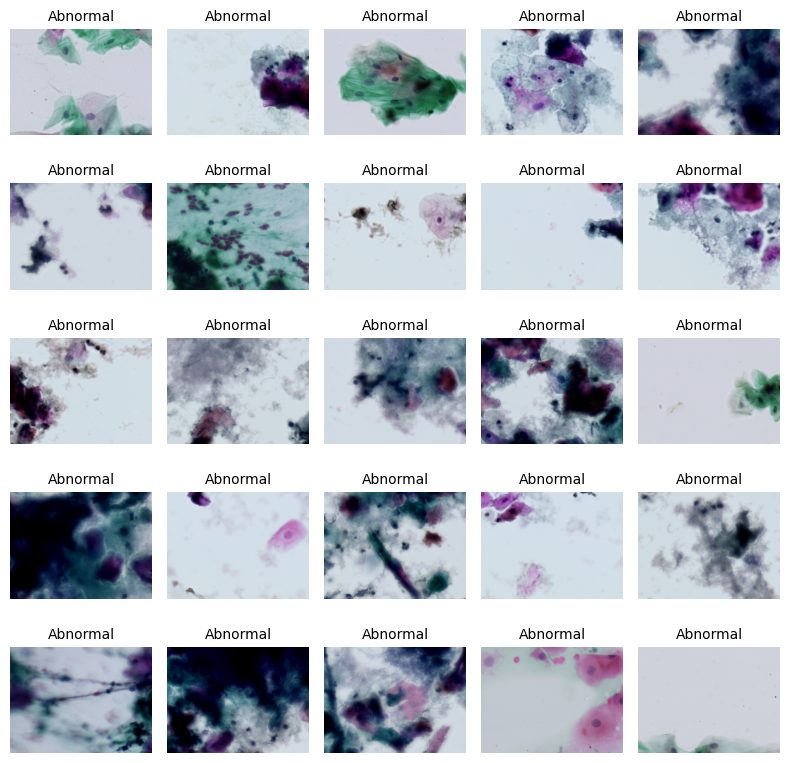

In [100]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Show first 25 abnormal images
fig, ax = plt.subplots(5, 5, figsize=(8,8))

for i, img_path in enumerate(IMG_DIR[1][:25]):
    img = mpimg.imread(img_path)
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].set_title("Abnormal", fontsize=10)
    ax[i//5, i%5].axis('off')

plt.tight_layout()
plt.show()

In [101]:
image_paths = glob.glob(IMG2_ROOT + '*/*')

print(len(image_paths))
for img_path in image_paths:
    # normal
    # Append to respective list
    IMG_DIR[0].append(img_path)

print(f"Total normal images: {len(IMG_DIR[0])}")
print(f"Total abnormal images: {len(IMG_DIR[1])}")

100
Total normal images: 100
Total abnormal images: 100


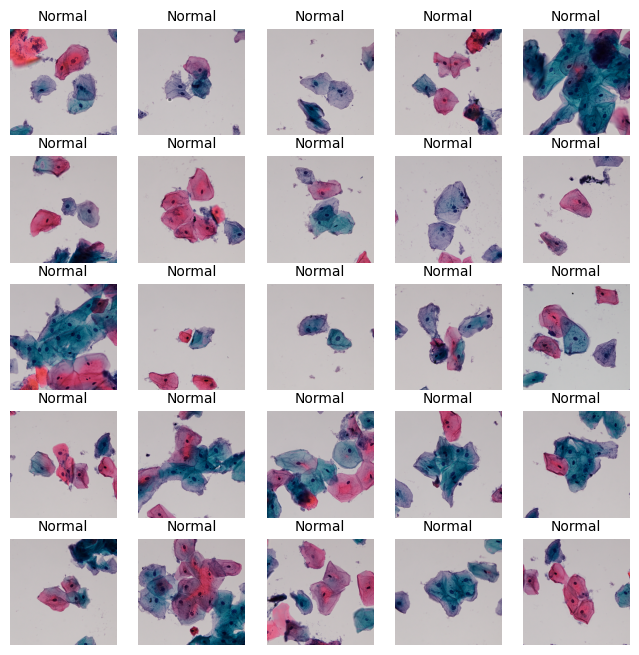

In [102]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, ax = plt.subplots(5, 5, figsize=(8,8))
for i, img_path in enumerate(IMG_DIR[0][:25]):
    img = mpimg.imread(img_path)
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].set_title("Normal", fontsize=10)
    ax[i//5, i%5].axis('off')
plt.show()

In [103]:
df = pd.DataFrame({
    'filepath': IMG_DIR[0] + IMG_DIR[1],
    'cancer': [0] * len(IMG_DIR[0]) + [1] * len(IMG_DIR[1])
})

In [104]:
train_df, test_df = train_test_split(df, 
                                     test_size=0.2, 
                                     random_state=SEED, 
                                     stratify=df['cancer'])

train_df, val_df = train_test_split(train_df,
                                    test_size=0.15,
                                    random_state=SEED,
                                    stratify=train_df['cancer'])

In [105]:
print(f"Train set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images\n")

print("Class distribution (train):")
print(train_df['cancer'].value_counts())
print("\n")

print("Class distribution (test):")
print(test_df['cancer'].value_counts())
print("\n")

print("Class distribution (validation):")
print(val_df['cancer'].value_counts())


Train set: 136 images
Validation set: 24 images
Test set: 40 images

Class distribution (train):
cancer
0    68
1    68
Name: count, dtype: int64


Class distribution (test):
cancer
0    20
1    20
Name: count, dtype: int64


Class distribution (validation):
cancer
0    12
1    12
Name: count, dtype: int64


In [106]:
IMG_WIDTH=224
IMG_HEIGHT=224

In [107]:
def create_datasets(df, IMG_WIDTH, IMG_HEIGHT):
    imgs = []
    for path in tqdm(df['filepath']):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        imgs.append(img)
        
    imgs = np.array(imgs, dtype='float32')
    df = pd.get_dummies(df['cancer'])
    return imgs, df


train_imgs, train_df = create_datasets(train_df, IMG_WIDTH, IMG_HEIGHT)
val_imgs, val_df = create_datasets(val_df, IMG_WIDTH, IMG_HEIGHT)
test_imgs, test_df = create_datasets(test_df, IMG_WIDTH, IMG_HEIGHT)

train_imgs = train_imgs / 255.0
val_imgs = val_imgs / 255.0
test_imgs = test_imgs / 255.0

100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 42.12it/s]


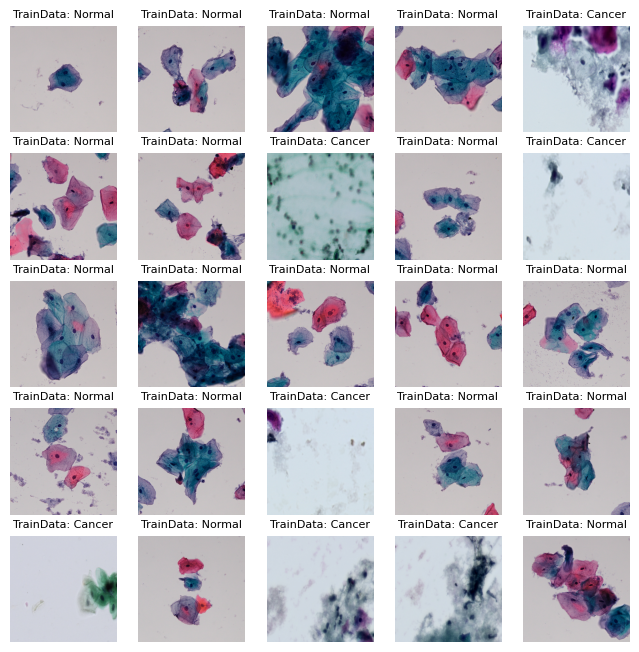

In [108]:
# plot the first 25 sheets of image data for training

f, ax = plt.subplots(5, 5, figsize=(8,8))
norm_list = list(train_df[0][:25])
for i, img in enumerate(train_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TrainData: Normal', fontsize=8)
    else:
        ax[i//5, i%5].set_title('TrainData: Cancer', fontsize=8)
plt.show()

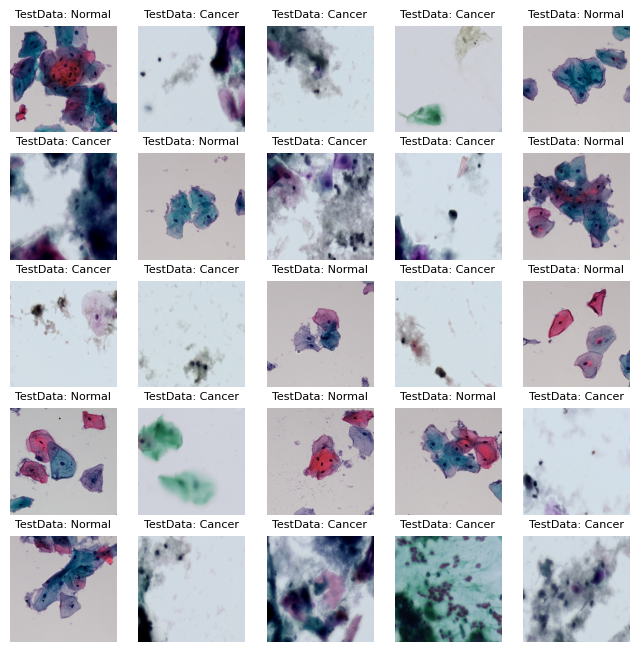

In [109]:
# plot the first 25 sheets of image data for Test
f, ax = plt.subplots(5, 5, figsize=(8,8))
norm_list = list(test_df[0][:25])
for i, img in enumerate(test_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TestData: Normal', fontsize=8)
    else:
        ax[i//5, i%5].set_title('TestData: Cancer', fontsize=8)
plt.show()

In [110]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    efnet = efn.EfficientNetB0(
        input_shape=(img_height,img_width,n), 
        weights='imagenet', 
        include_top=False
    )
    x = efnet(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy',tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')])
    return model

model = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnet-b0 (Functional)    │ (None, 7, 7, 1280)     │     4,049,564 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,052,126 (15.46 MB)

 Trainable params: 4,010,110 (15.30 MB)

 Non-trainable params: 42,016 (164.12 KB)

In [111]:
generator = ImageDataGenerator(horizontal_flip=True, 
                               height_shift_range=0.1,
                               fill_mode='reflect') 


es_callback = tf.keras.callbacks.EarlyStopping(patience=20, 
                                               verbose=1, 
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=10, verbose=1)

/opt/anaconda3/envs/env9/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.6577 - auc: 0.6942 - loss: 0.6419 - precision: 0.6577 - recall: 0.6577 - val_accuracy: 0.2917 - val_auc: 0.2674 - val_loss: 0.8196 - val_precision: 0.2917 - val_recall: 0.2917 - learning_rate: 1.0000e-05
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8002 - auc: 0.8449 - loss: 0.5617 - precision: 0.8002 - recall: 0.8002 - val_accuracy: 0.3750 - val_auc: 0.2830 - val_loss: 0.8172 - val_precision: 0.3750 - val_recall: 0.3750 - learning_rate: 1.0000e-05
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8874 - auc: 0.9285 - loss: 0.4914 - precision: 0.8874 - recall: 0.8874 - val_accuracy: 0.3333 - val_auc: 0.3741 - val_loss: 0.7890 - val_precision: 0.3333 - val_recall: 0.3333 - learning_rate: 1.0000e-05
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8760 - auc: 0.9477 - loss: 0.4382 - precision: 0.8760 - recall: 0.8760 - val_accuracy: 0.5833 - val_auc: 0.5139 - val_loss: 0.7551 -

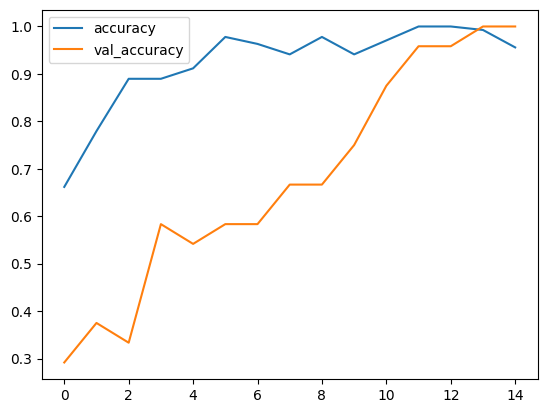

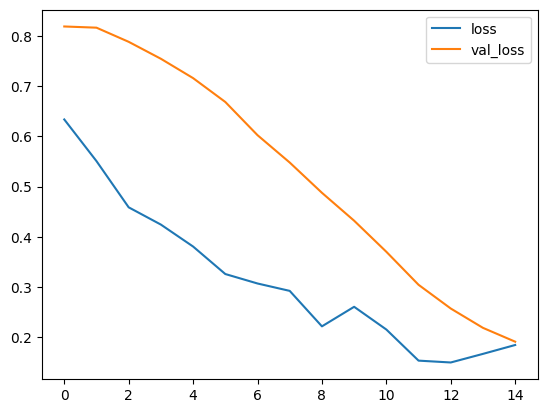

In [112]:
history = model.fit(
    generator.flow(train_imgs, train_df, batch_size=8), 
    epochs=15,
    callbacks=[es_callback, reduce_lr],
    validation_data=(val_imgs, val_df)
)


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

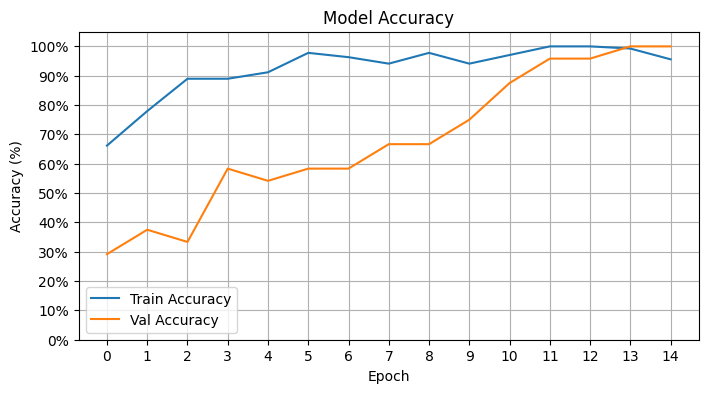

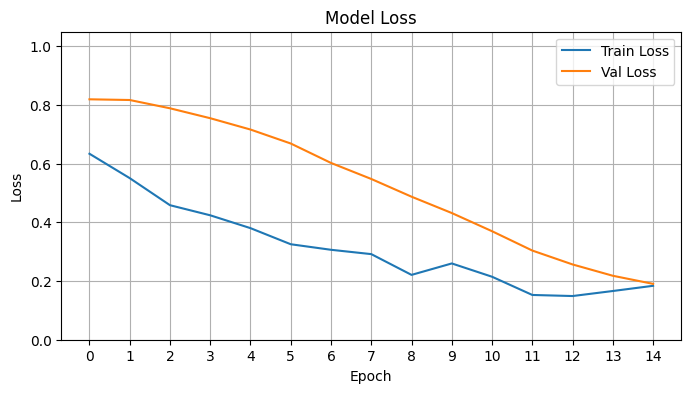

In [113]:
import matplotlib.pyplot as plt
import pandas as pd

history_df = pd.DataFrame(history.history)

# Accuracy plot (Y-axis 0–100%)
plt.figure(figsize=(8, 4))
plt.plot(history_df['accuracy'], label='Train Accuracy')
plt.plot(history_df['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 1.05)  # Accuracy values are in 0.0–1.0 range (not percent)
plt.yticks([i/10 for i in range(11)], [f"{i*10}%" for i in range(11)])  # Convert to percent labels
plt.xticks(range(len(history_df)))
plt.legend()
plt.grid(True)
plt.show()

# Loss plot (standard scale)
plt.figure(figsize=(8, 4))
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xticks(range(len(history_df)))
plt.ylim(0, 1.05)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [126]:
from sklearn.metrics import f1_score
# Predict probabilities
y_pred_probs = model.predict(val_imgs)

# Convert probabilities to binary predictions
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Get true labels
# If val_df is just a Series of 0s and 1s:
y_true = val_df if isinstance(val_df, (np.ndarray, list, pd.Series)) else val_df.values
y_true = y_true.flatten()

# After predictions

f1 = f1_score(y_true, y_pred)
print("F1 Score:", round(f1, 4))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
F1 Score: 1.0


In [115]:
from sklearn.metrics import confusion_matrix
true_classes = test_df.loc[:, [0,1]].values
true_classes

y_pred=model.predict(test_imgs)
y_pred=(y_pred>0.5).astype(int)

print('Confusion Matrix')
cm=confusion_matrix(true_classes.argmax(axis=1),y_pred.argmax(axis=1))
cm

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 301ms/step
Confusion Matrix


array([[19,  1],
       [ 1, 19]])

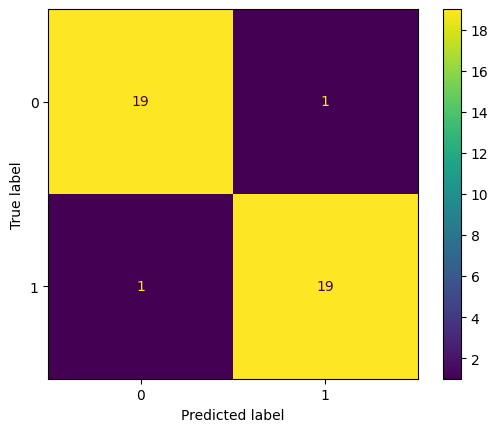

In [116]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [117]:
from sklearn.metrics import roc_auc_score
x=roc_auc_score(true_classes, y_pred, average='macro')
print('roc_auc_value')
print(x)

roc_auc_value
0.95


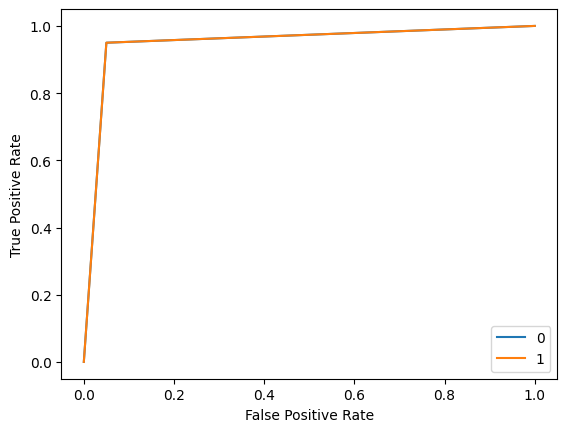

In [118]:
#ROC curve
classes=['normal','abnormal']
from sklearn.metrics import roc_curve
for i in range(true_classes.shape[-1]):
    fprs, tprs, _ = roc_curve(true_classes[:,i], y_pred[:,i]) #calculate fprs and tprs for each class
    plt.plot(fprs,tprs,label='{}'.format(i)) #plot roc curve of each class
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

In [119]:
def calculate_sensitivity_specificity(y_test, y_pred_test):
    actual_pos = y_test == 1
    actual_neg = y_test == 0
    
    true_pos = (y_pred_test == 1) & (actual_pos)
    false_pos = (y_pred_test == 1) & (actual_neg)
    true_neg = (y_pred_test == 0) & (actual_neg)
    false_neg = (y_pred_test == 0) & (actual_pos)
    
    # Calculate sensitivity and specificity
    sensitivity = np.sum(true_pos) / np.sum(actual_pos)
    specificity = np.sum(true_neg) / np.sum(actual_neg)
    
    return sensitivity, specificity

In [125]:
sensitivity, specificity = calculate_sensitivity_specificity(y_true, y_pred)
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

Sensitivity: 0.9500
Specificity: 0.9500


In [121]:
# Predict
y_pred = (model.predict(test_imgs) > 0.5).astype(int).flatten()

# Convert one-hot encoded labels to integers
y_true = test_df.values.argmax(axis=1) if isinstance(test_df, pd.DataFrame) else test_df
y_true = test_df.values.flatten()

# Check lengths
assert len(y_true) == len(y_pred), "Mismatch between y_true and y_pred lengths"

# Report
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred, target_names=["Normal", "Abnormal"]))


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step
              precision    recall  f1-score   support

      Normal       0.95      0.95      0.95        40
    Abnormal       0.95      0.95      0.95        40

    accuracy                           0.95        80
   macro avg       0.95      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80



In [122]:
model.evaluate(test_imgs, test_df)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step - accuracy: 0.9458 - auc: 0.9966 - loss: 0.2187 - precision: 0.9458 - recall: 0.9458


[0.2226802557706833,
 0.949999988079071,
 0.949999988079071,
 0.949999988079071,
 0.9965624809265137]

In [127]:
from sklearn.metrics import cohen_kappa_score
print("Cohen’s Kappa:", cohen_kappa_score(y_true, y_pred))

Cohen’s Kappa: 1.0


In [490]:
model.save("model.h5")